**Questão de negócio**: previsão de venda das próximas 6 semanas

**Entendimento do Negócio:** CFO precisa saber quanto cada loja vai gerar de lucro
pra poder investir a grana correta

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from matplotlib import pyplot as plt
from IPython.core.display import HTML
import datetime
from IPython.display import Image

In [2]:
#função para melhorar a exibição dos gráficos

def jupyter_settings():
  %matplotlib inline
  %pylab inline
  plt.style.use( 'bmh' )
  plt.rcParams['figure.figsize'] = [25, 12]
  plt.rcParams['font.size'] = 24
  display( HTML( '<style>.container { width:100% !important; }</style>') )
  pd.options.display.max_columns = None
  pd.options.display.max_rows = None
  pd.set_option( 'display.expand_frame_repr', False )
  sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [4]:
df_sales_raw = pd.read_csv( 'train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'store.csv', low_memory=False )
# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# Descrição dos Dados

In [5]:
df1 = df_raw.copy()

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open',
'Promo', 'StateHoliday', 'SchoolHoliday',
'StoreType', 'Assortment', 'CompetitionDistance',
'CompetitionOpenSinceMonth',
'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore( x )
cols_new = list( map( snakecase, cols_old ) )
# rename
df1.columns = cols_new

In [7]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


In [8]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [10]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
850788,829,4,2013-05-30,0,0,0,1,a,0,c,a,110.0,NaN,NaN,0,NaN,NaN,NaN


# Formas de tratar um NA:
-1: Excluindo os NA's, porém eu perco dados.

-2: Algoritmos de machine learning que vão entender o comportamento da coluna.

-3: Pensando no negócio: 

In [11]:
#df1['competition_distance'] sem NA's
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

# 1.5 Fillout NA


In [12]:
#Abaixo segue todas as colunas que possuem os NA que precisam ser tratados

#1-competition_distance              
#2-competition_open_since_month    
#3-competition_open_since_year                                   
#4-promo2_since_week               
#5-promo2_since_year               
#6-promo_interval                  

In [13]:
#1-competition_distance  
# - Ou não tem competidor perto, ou está tão longe que considera que não tenha. 

df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000 if math.isnan(x)  else x)

In [14]:
#2-competition_open_since_month

df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] )
                                                 else x['competition_open_since_month'], axis=1 )

In [15]:
#3-competition_open_since_year

df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] )
                                                else x['competition_open_since_year'], axis=1 )


In [16]:
#4-promo2_since_week 

df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week'] ) 
                                     else x['promo2_since_week'], axis=1 )

In [17]:
#5-promo2_since_year

df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year'] ) 
                                     else x['promo2_since_year'], axis=1 )

In [18]:
#6- promo_interval
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
703966,72,2,2013-10-08,6191,572,1,1,0,0,a,a,2200.0,12.0,2009.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [19]:
df1['promo_interval'].fillna(0, inplace=True )
df1['promo_interval'].head()

0                  0
1    Jan,Apr,Jul,Oct
2    Jan,Apr,Jul,Oct
3                  0
4                  0
Name: promo_interval, dtype: object

In [20]:
#promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

In [21]:
#criação da month map
# .map: retira o valor da chave
df1['month_map'] = df1['date'].dt.month.map( month_map )

In [22]:
df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 
                                                             else 1 if x['month_map'] in x['promo_interval'].split( ',' ) 
                                                             else 0, axis=1 )

# 1.7 Estatistica Descritiva

- Precisamos separar as variáveis numéricas e as variáveis categóricas

- Skew: se refere as caudas da curva

- Kurtosis: se refere ao achatamento da curva 


In [23]:
#dataframe com os atributos numéricos
num_attributes = df1.select_dtypes( include= ['int64', 'float64'])
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9.0,2008.0,0,31.0,2015.0,0
1,2,5,6064,625,1,1,1,570.0,11.0,2007.0,1,13.0,2010.0,1
2,3,5,8314,821,1,1,1,14130.0,12.0,2006.0,1,14.0,2011.0,1
3,4,5,13995,1498,1,1,1,620.0,9.0,2009.0,0,31.0,2015.0,0
4,5,5,4822,559,1,1,1,29910.0,4.0,2015.0,0,31.0,2015.0,0


In [24]:
cat_attributes = df1.select_dtypes( exclude= ['int64', 'float64', 'datetime64[ns]'])
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


### 1.7.1 Atributos Numéricos

In [25]:
# Tendência central: Média e Mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean) ).T

ct2 = pd.DataFrame(num_attributes.apply(np.median) ).T

In [26]:
# Dispersão: std, min, max, range, skew, kurtosis

d1 = pd.DataFrame(num_attributes.apply(np.std) ).T
d2 = pd.DataFrame(num_attributes.apply(min ) ).T
d3 = pd.DataFrame(num_attributes.apply(max ) ).T
#Para fazer o range: max - min
## como eu preciso fazer uma função que passar por todos os items do dataframe
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T


#### Estatísticas de 1º ordem


In [27]:
#concatenando

m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std',
             'skew', 'kurtosis']

In [28]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


D:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

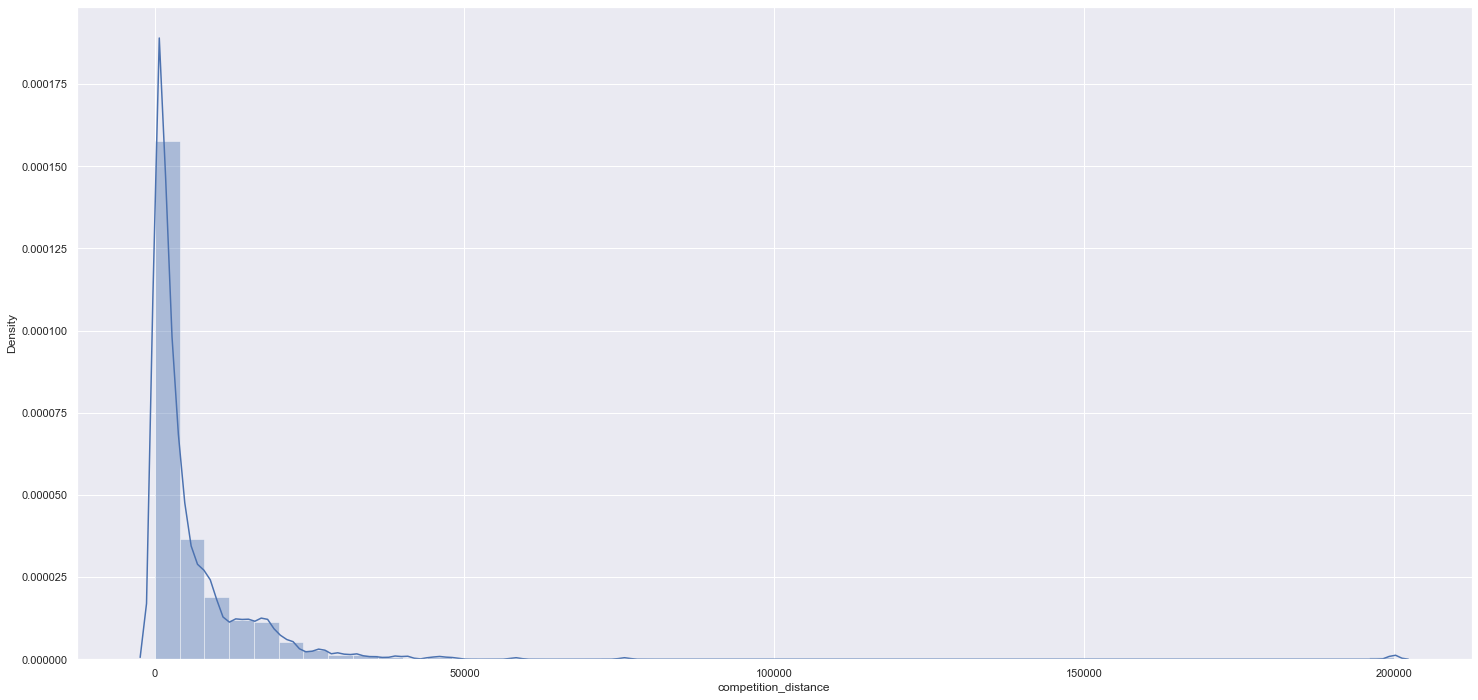

In [29]:
#exemplo: competition distance
sns.distplot( df1['competition_distance'])

### 1.7.2 Atributos Categóricos

In [30]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

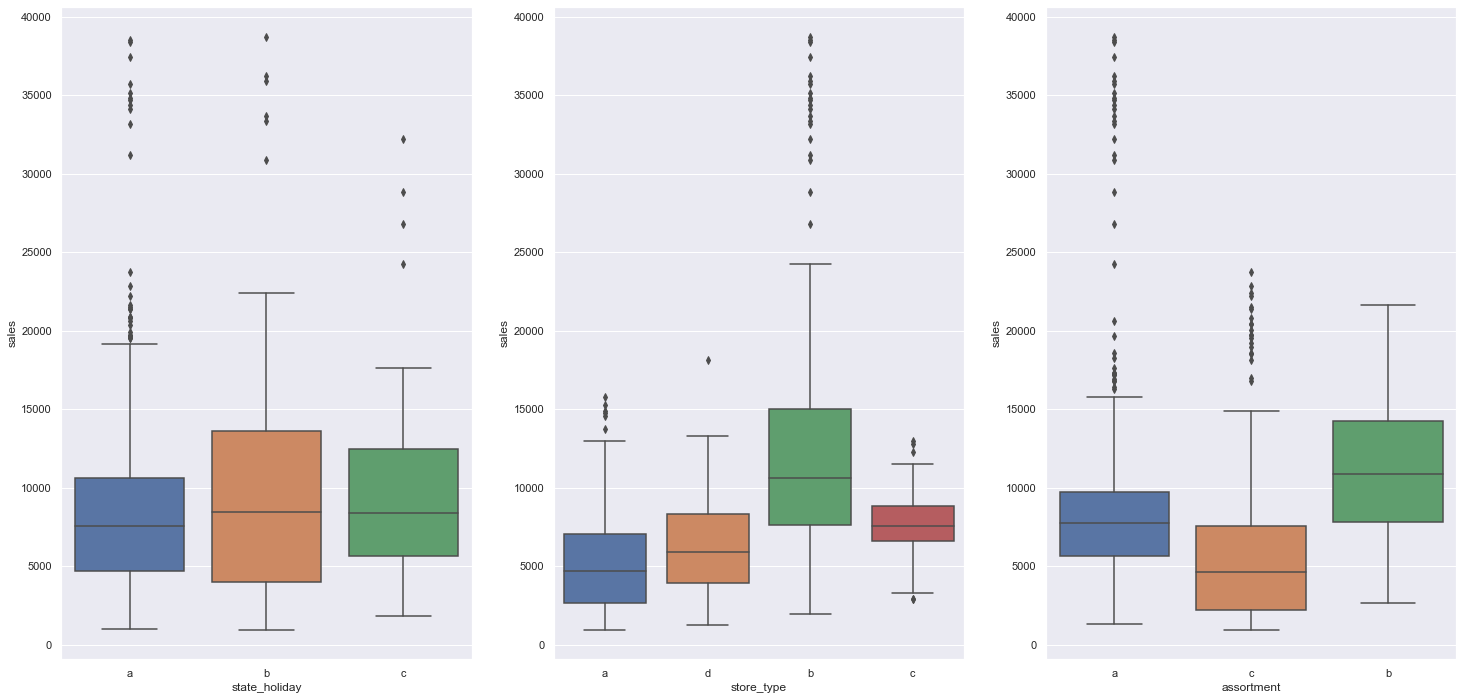

In [31]:
#Boxplot das variáveis categóricas

aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

#indice do subplot
plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )


# 2.0 Feature Engineering



## Mapa Mental de Hipóteses
  Fenômeno: qual fenômeno estou modelando ?

  Agentes: quem são os agentes que atuam sobre o fenômeno de interesse ?

  Atributos dos agentes: qual a descrição dos agentes ?

  Lista de Hipóteses: cada hipótese validada ou descartada, é o famoso insight

In [32]:
from IPython.display import Image

In [33]:
Image('/content/mindmap.png')

FileNotFoundError: No such file or directory: '/content/mindmap.png'

FileNotFoundError: No such file or directory: '/content/mindmap.png'

<IPython.core.display.Image object>

## Hipóteses são Apostas.

- Lojas de MAIOR porte, deveriam vender MAIS.
-- Porte é um atributo do agente loja.
-- Vender é a minha variável resposta do fenômeno que estou tentando modelar, as vendas das lojas

## 2.1 Criação das Hipóteses

### 2.1.1 Hipoteses Loja

### 2.1.2 Hipoteses Produto

### 2.1.3 Hipoteses Tempo

### 2.1.4 Change Data types

In [34]:
df2 = df1.copy()

In [35]:
# preciso converter para a int, pois o datetime estava tendo problemas com o float

# competition_open_since
df2['competition_open_since_month'] = df2['competition_open_since_month'].astype(int)
df2['competition_open_since_year'] = df2['competition_open_since_year'].astype(int)

# promo2
df2['promo2_since_week'] = df2['promo2_since_week'].astype( int )
df2['promo2_since_year'] = df2['promo2_since_year'].astype( int )

In [36]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 2.4 Feature Engineering

###  - Criação das features a partir dos dados que temos

In [37]:
########### Dates Features ########################

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

########### Others Features ######################

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'],
                                                                  month=x['competition_open_since_month'], day=1 ), axis=1 )

df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
## data atual - o inicio da promoção
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

 
# assortment
## trocando os simbolos de cada assortment para os nomes
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' 
                                            else 'extra' if x == 'b' 
                                            else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' 
                                                  else 'easter_holiday' if x == 'b' 
                                                  else 'christmas' if x == 'c'
                                                  else 'regular_day' )

<ipython-input-37-f9fe91ccc8e5>:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [38]:
# Metodologia CRISP
Image('/content/Exploração dos Dados.png')

FileNotFoundError: No such file or directory: '/content/Exploração dos Dados.png'

FileNotFoundError: No such file or directory: '/content/Exploração dos Dados.png'

<IPython.core.display.Image object>

# 3.0 Filtragem das variáveis

In [39]:
df3 = df2.copy()
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das linhas

### - Como vendas é a variável resposta, filtro tudo aonde não ocorrem as vendas.

In [40]:
#relação direta: se a loja não abre, tenho venda 0
df3 = df3[(df3['open'] != 0 ) & (df3['sales'] > 0)]
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.2 Seleção das Colunas

In [41]:
#não tenho as informações dos clientes depois das 6 semanas
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop ( cols_drop, axis = 1)

#4.0 Análise Exploratória dos Dados (EDA)

Quais os 3 objetivos da EDA ?
- Ganhar experiência no negócio
- Validar Hipóteses de Negócio ( Insight's)
- Perceber variáveis que são importantes para o modelo 

In [42]:
df4 = df3.copy()

## 4.1 Análise Univariada

- Como é essa varíavel (Min, Max, Distribuição, Range,...)

### 4.1.1 Response Variable

D:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


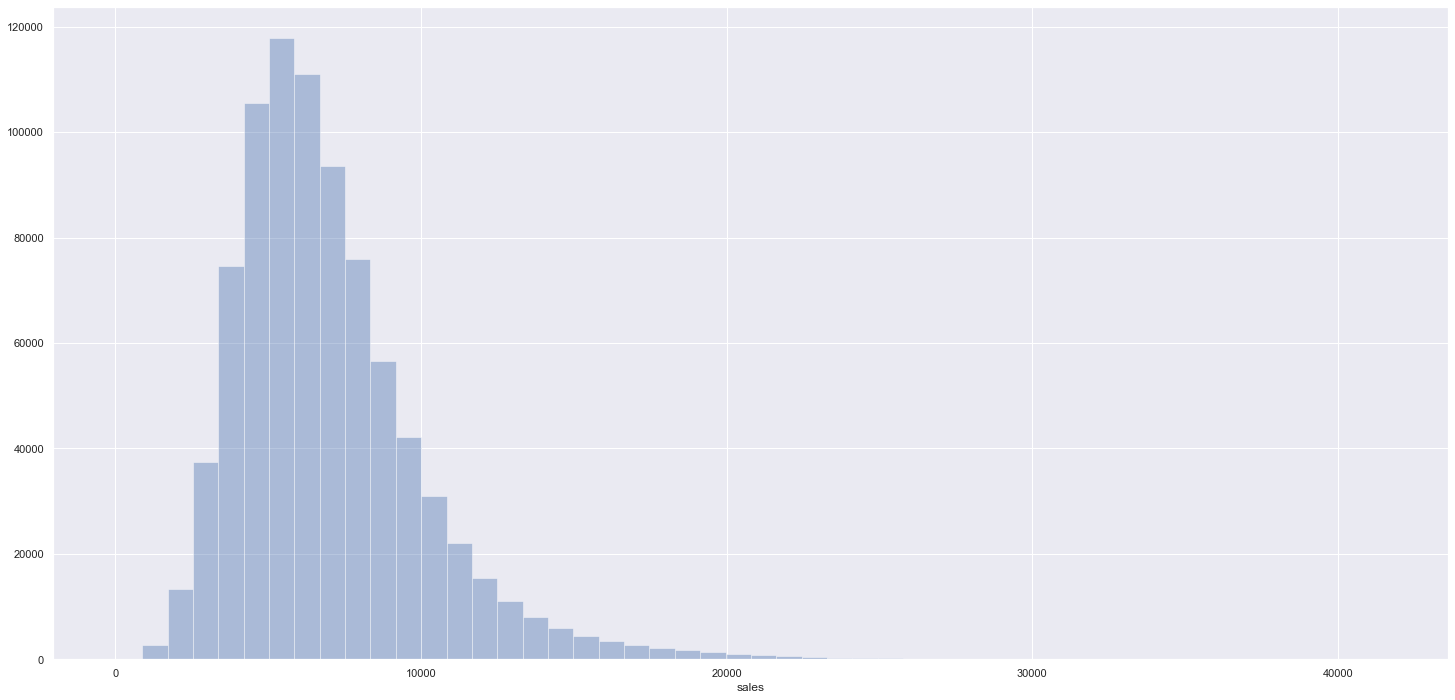

In [43]:
sns.distplot( df4['sales'], kde=False );

### 4.1.2 Numerical Variable

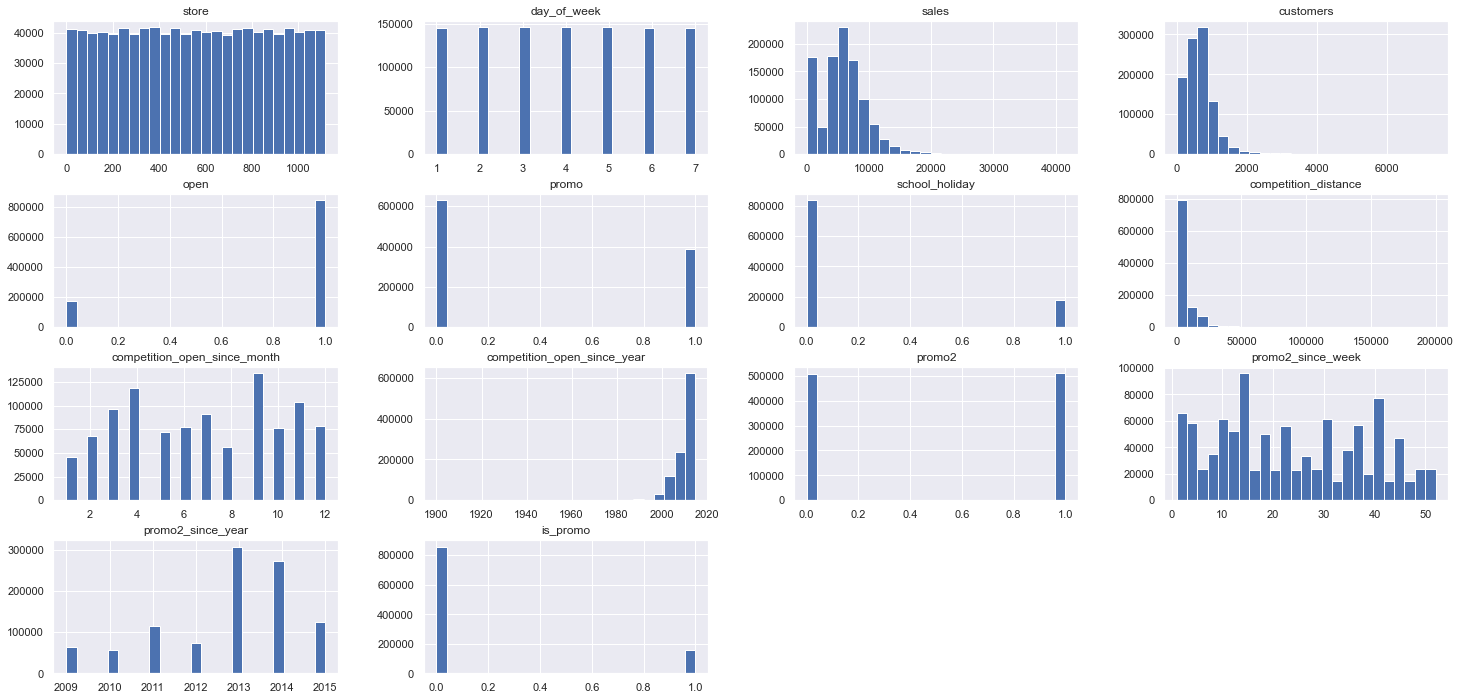

In [44]:
num_attributes.hist(bins = 25);

In [45]:
# usamos o drop_duplicates e não o value_counts, para não repetir os dias
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='state_holiday', ylabel='count'>

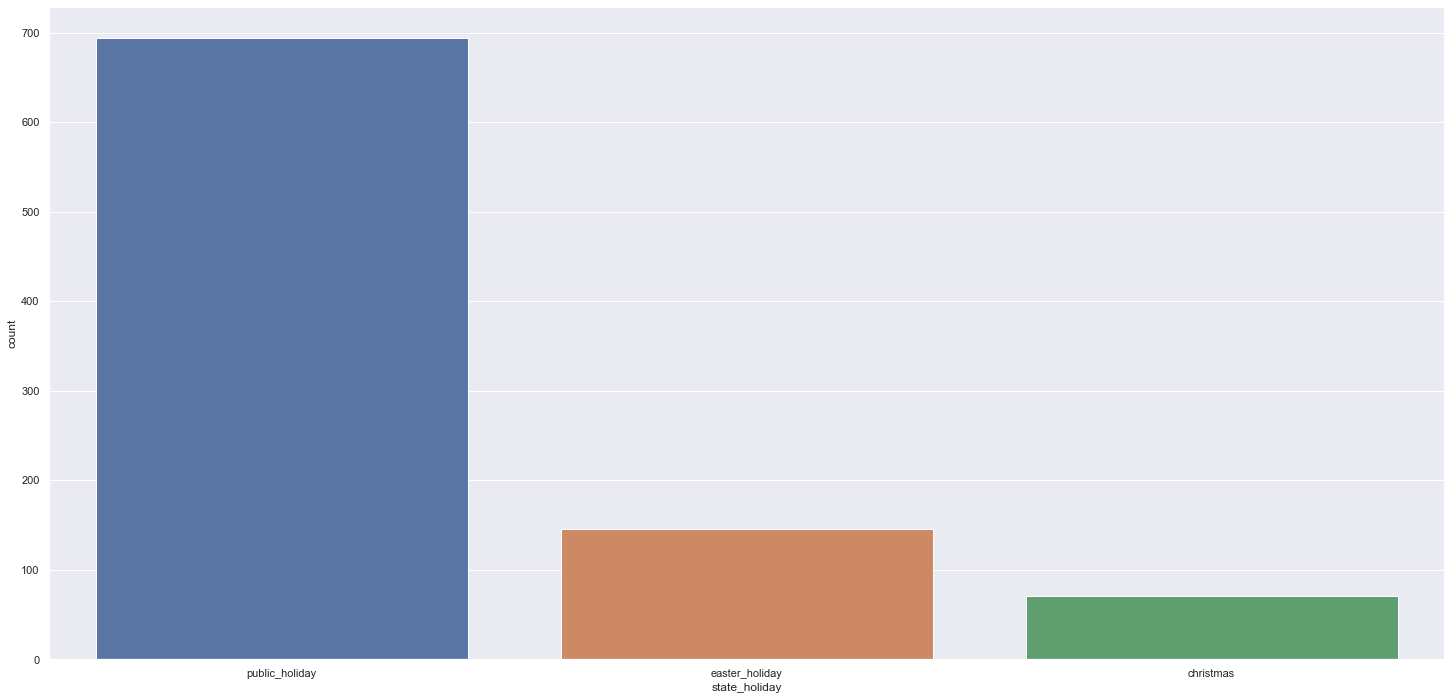

In [46]:
#retirando o regular_day do state_holiday
a = df4[df4['state_holiday'] != 'regular_day']

sns.countplot(a['state_holiday'])

Gráfico para plotar a quantidade de variáveis de uma coluna: sns.countplot()

### 4.1.3 Categorical Variable

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

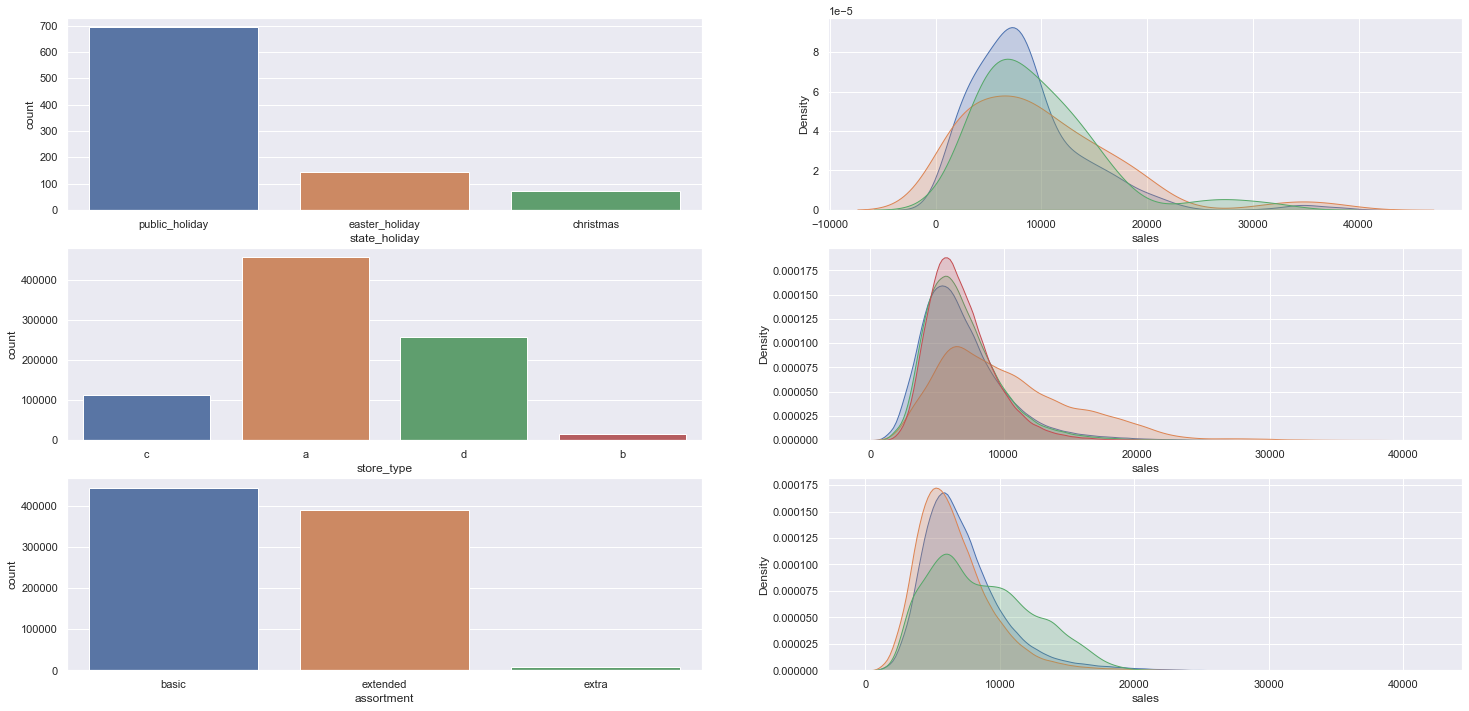

In [47]:
# state_holiday
## tirando o regular day porque tem muitos, para mostrar os outros no gráfico
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
# como se fosse um value counts, aonde só preciso por a coluna que eu quero
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'],
label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'],
label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'],
label='christmas', shade=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
# uma coluna do dataframe é equivalente a uma pandas.series
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended',
shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic',
shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra',
shade=True )

In [48]:
type(df4[df4['store_type'] == 'a']['sales'])

pandas.core.series.Series

## 4.2 Análise Bivariada
- Como a variável impacta na resposta ?
(correlação, validação das hipóteses,..)

In [49]:
df4[['store', 'sales', 'assortment']].groupby(['store', 'assortment'] ).sum().sort_values(by = 'sales', ascending = False).head()

,,sales
store,assortment,
262,basic,19516842
817,basic,17057867
562,extended,16927322
1114,extended,16202585
251,extended,14896870


### H1. Lojas com maior sortimentos deveriam vender mais.

FALSA Lojas com MAIOR SORTIMENTO vendem MENOS.



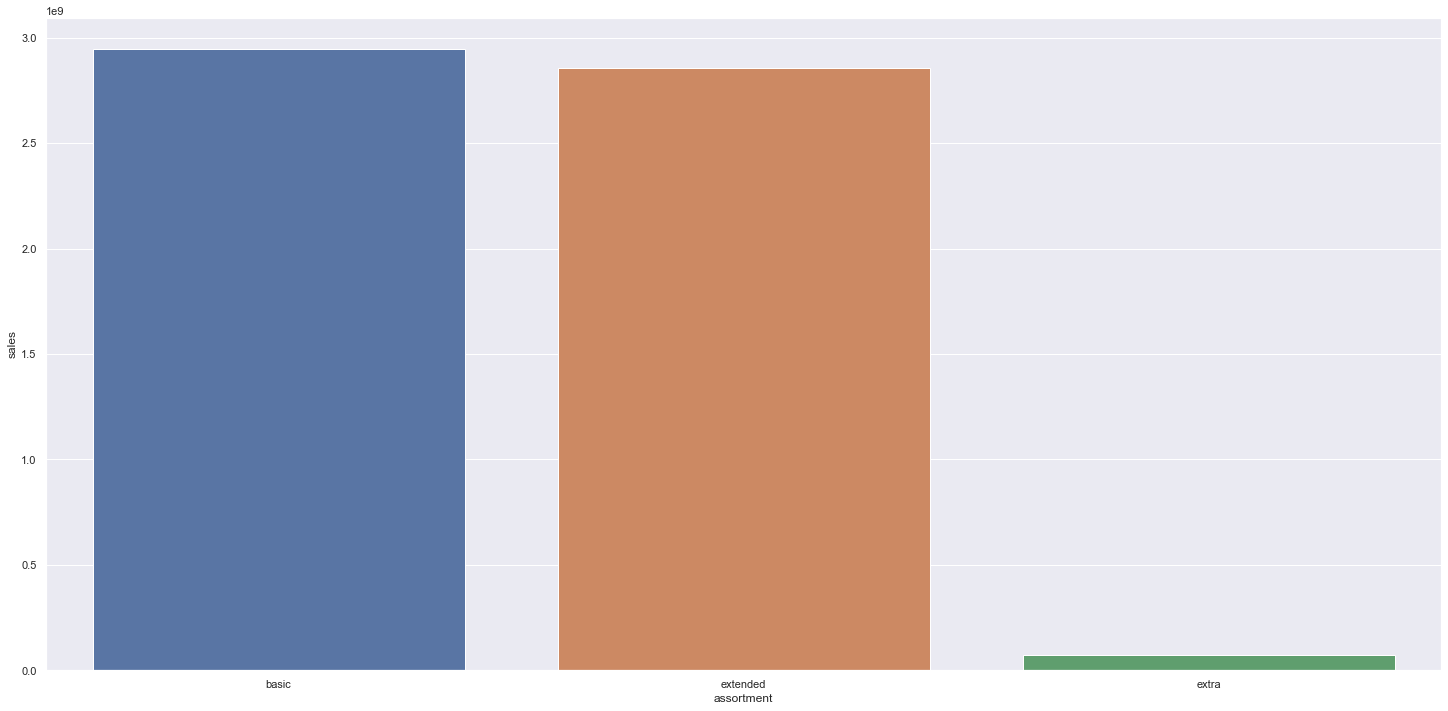

In [50]:
# mostrando que lojas com sortimentos basicos tem mais vendas que lojas com sortiments extended's
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

In [51]:
# dataframe organizado com as linhas year_week, colunas com os tipos de assortment com as somatórias das vendas
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment'] ).sum().reset_index()
#pivot = reorganiza o dataframe de acordo com as linhas e colunas que colocar na função
aux3 = aux2.pivot( index='year_week', columns='assortment', values='sales' )
aux3.head()

assortment,basic,extended,extra
year_week,,,
2013-00,13434262,12425669,269404
2013-01,26007250,22917693,350279
2013-02,17970974,16029584,377207
2013-03,24392076,21243431,404662
2013-04,19972891,18130077,363061


<AxesSubplot:xlabel='year_week'>

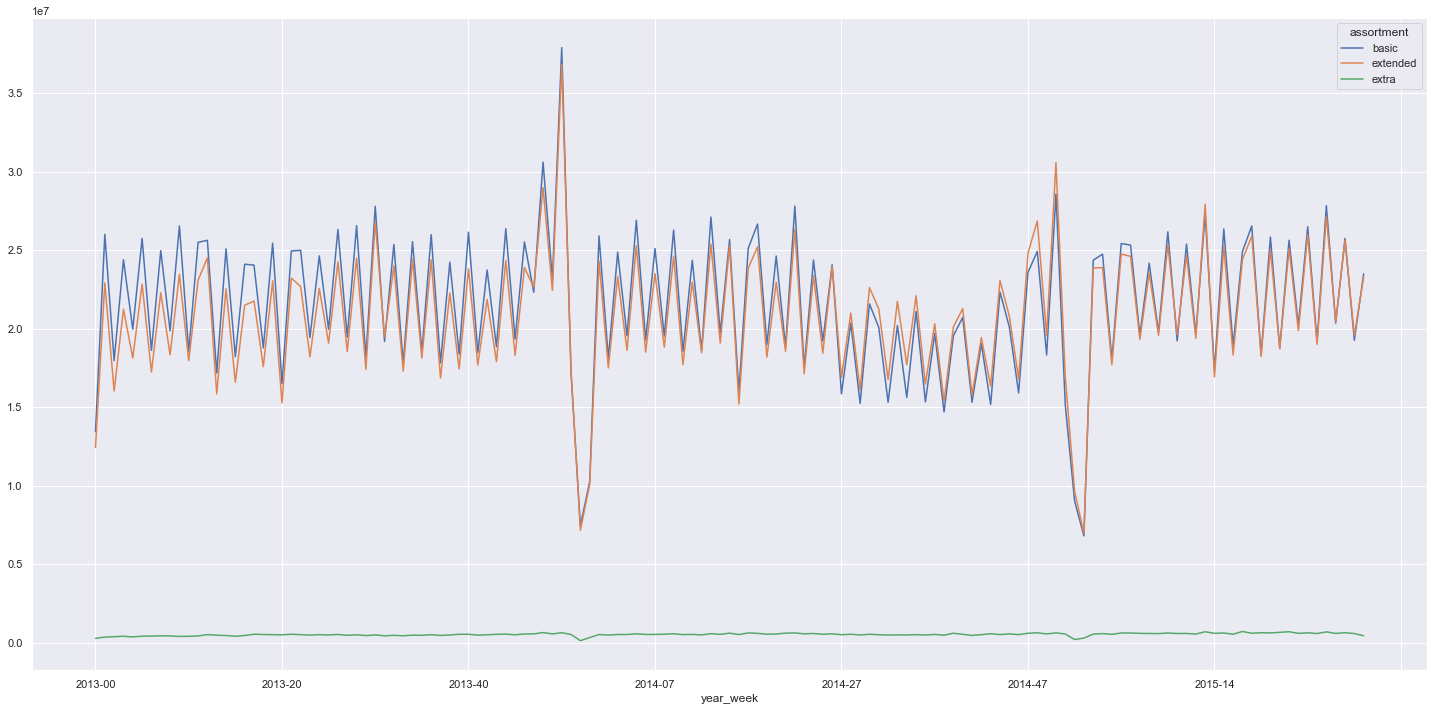

In [52]:
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

<AxesSubplot:xlabel='year_week'>

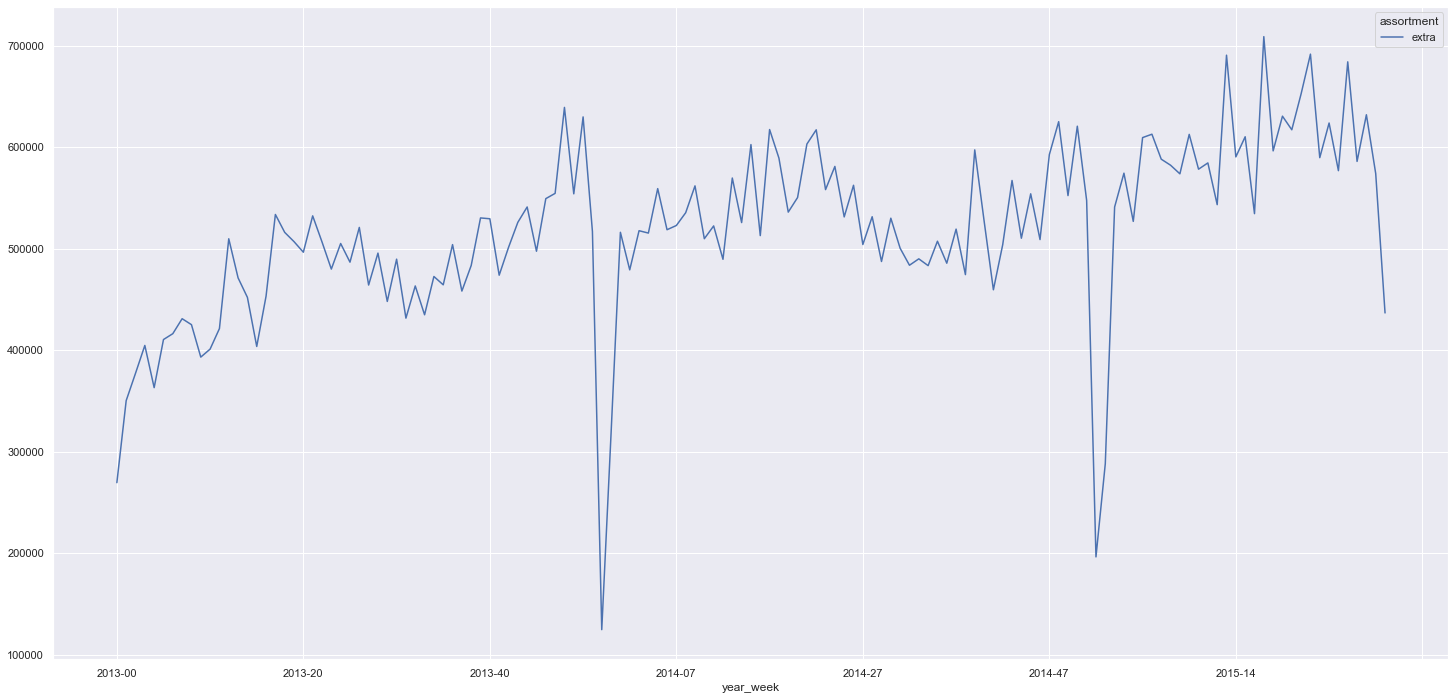

In [53]:
#verificando o comportamento apenas do extra, que no outro gráfico parece que é linear
## aux2['assortment'] == 'extra' pega só a condição booleana
## aux2[aux2[ pega todas as linhas e colunas

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.
FALSA Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.

#### .cut segmenta os meus valores em intervalos discretos

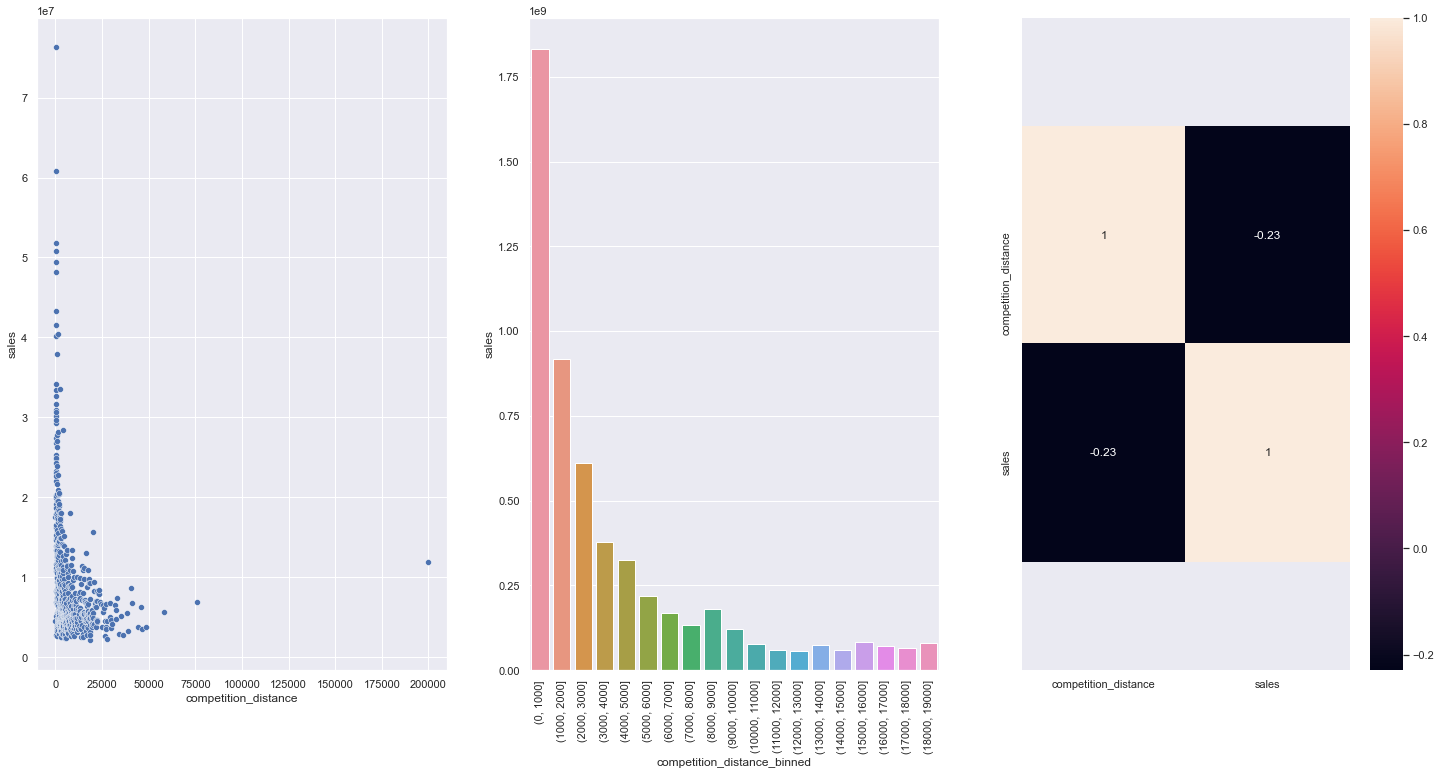

In [54]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
# criação de uma lista aonde eu posso organizar os valores
bins = list( np.arange( 0, 20000, 1000) )
# pd.cut: coloca a coluna selecionada dentro do bin que eu criei
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'],bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
# rotaciona os labels para não ficarem tudo junto
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

### H3. Lojas com competidores à mais tempo deveriam vendem mais.
FALSE Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

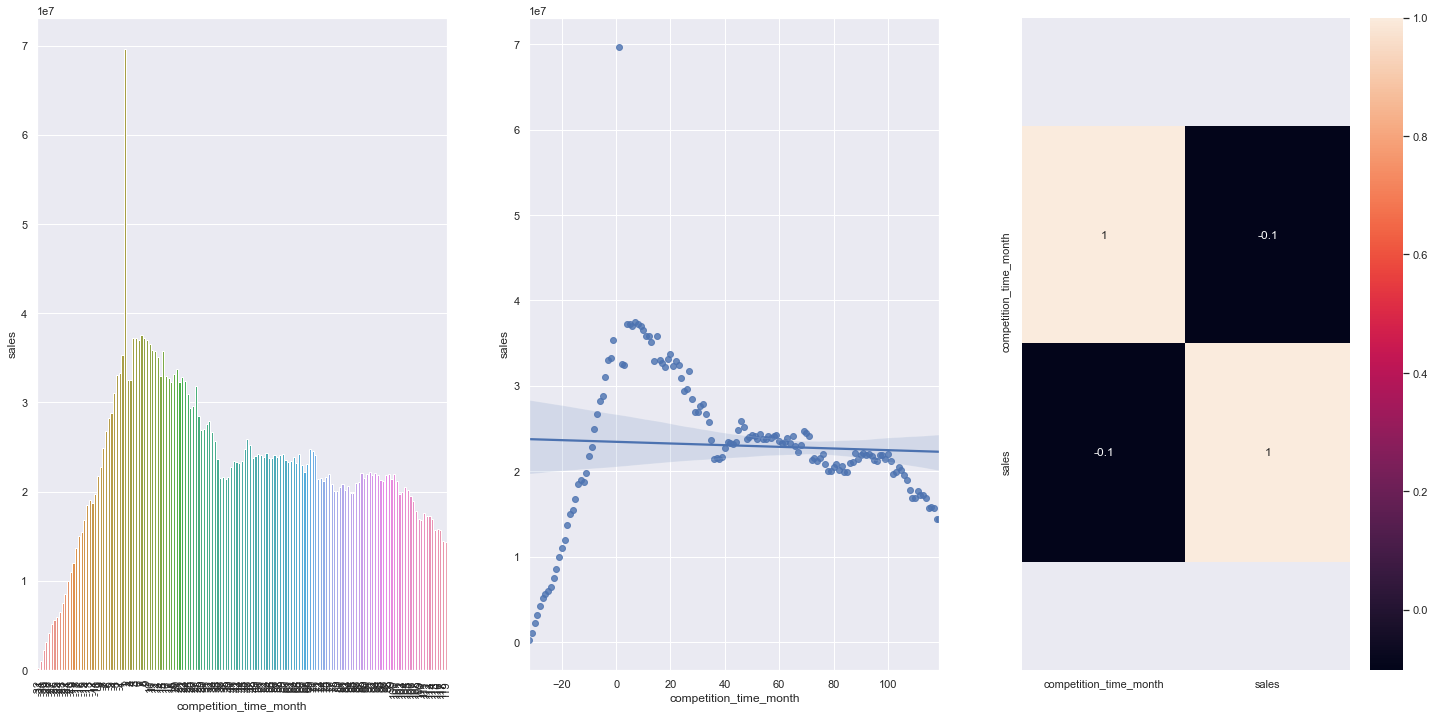

In [55]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
FALSA Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo
de promocao

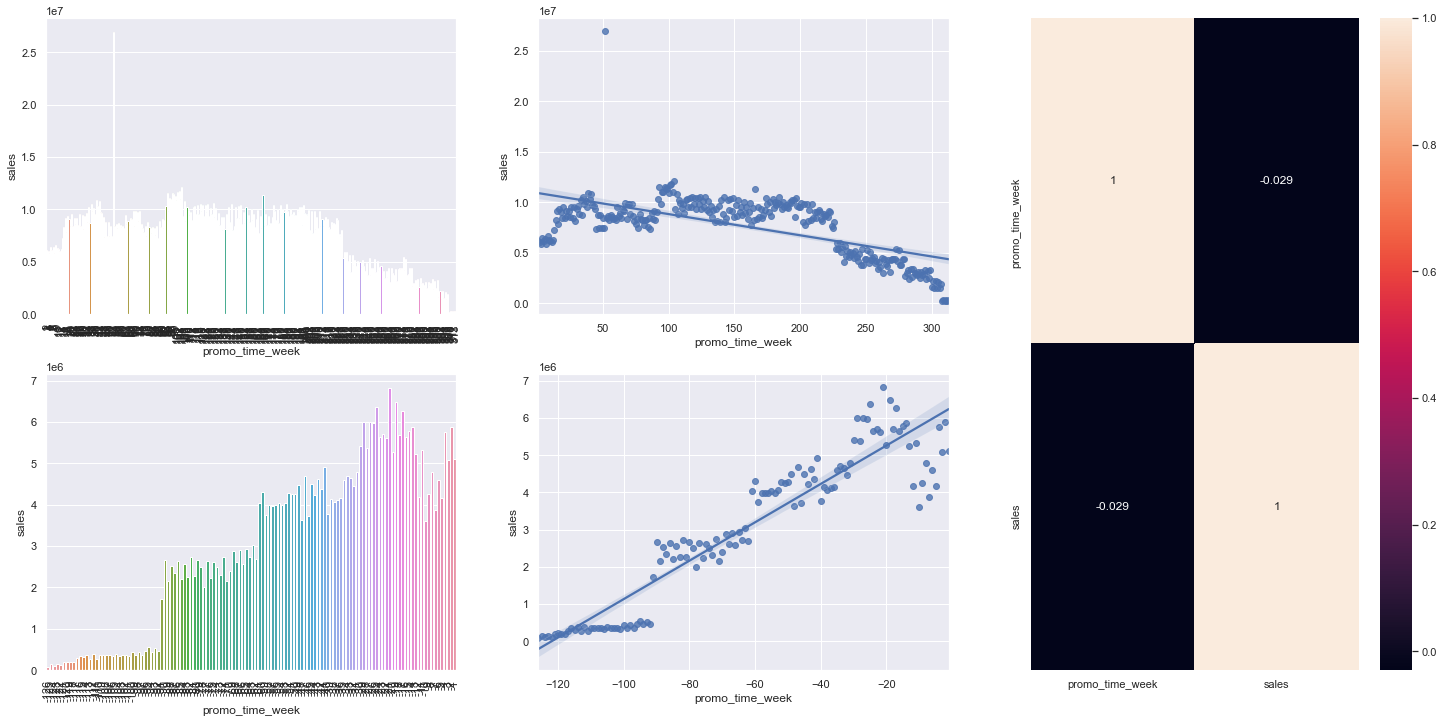

In [56]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )
plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

In [57]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


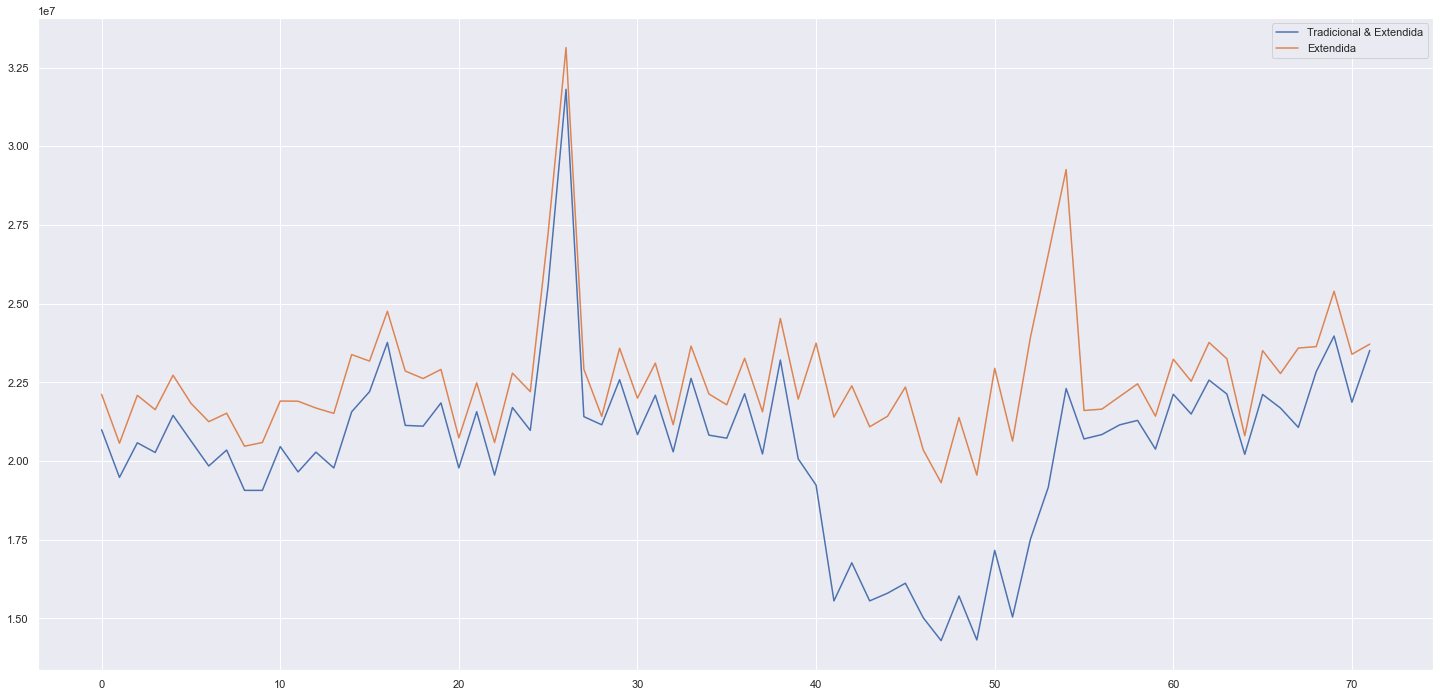

In [58]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### H8. Lojas abertas durante o feriado de Natal deveriam vender mais.
FALSA Lojas abertas durante o feriado do Natal vendem menos.

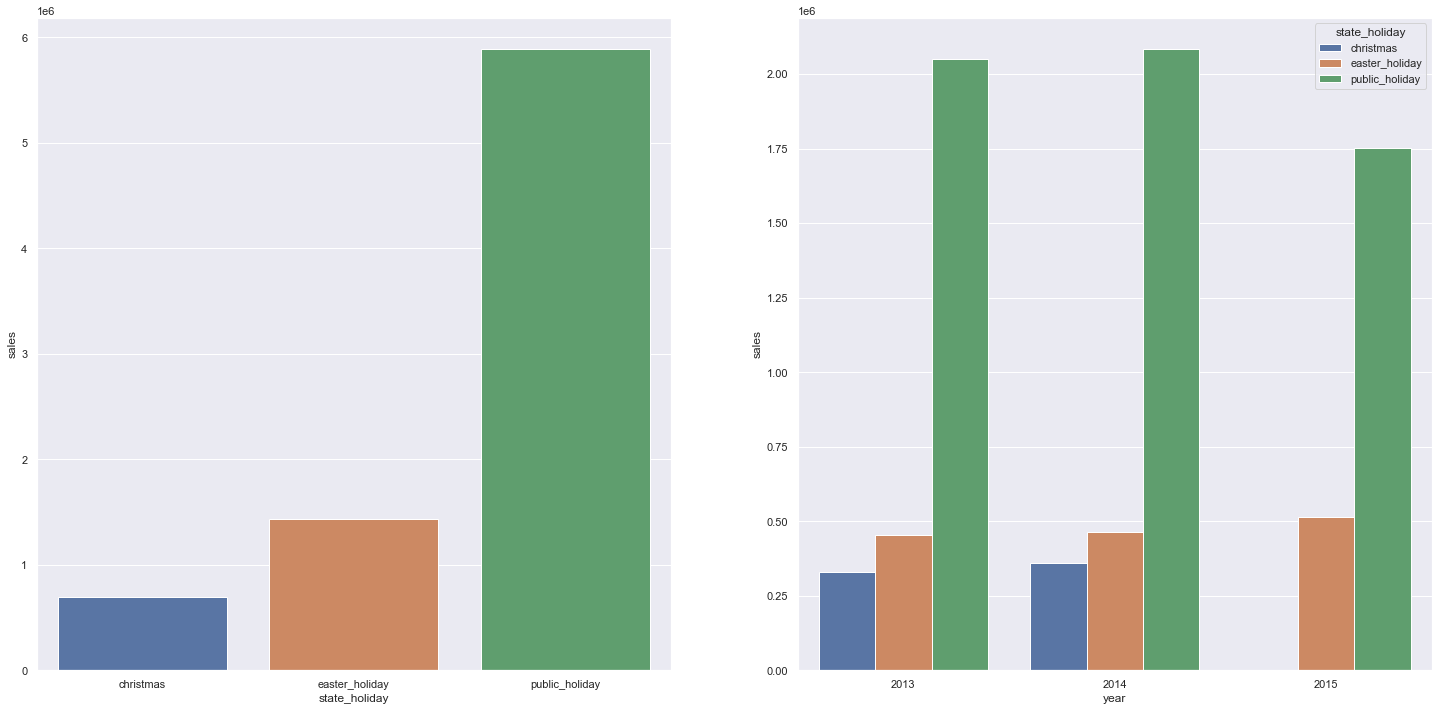

In [59]:
# filtrando os dias regulares
aux = df4[df4['state_holiday'] != 'regular_day']

#plotando apenas as vendas totais dos feriados
plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

#plotando as vendas dos feriados por ano
plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### H10. Lojas deveriam vender mais no segundo semestre do ano.
FALSA Lojas vendem menos no segundo semestre do ano

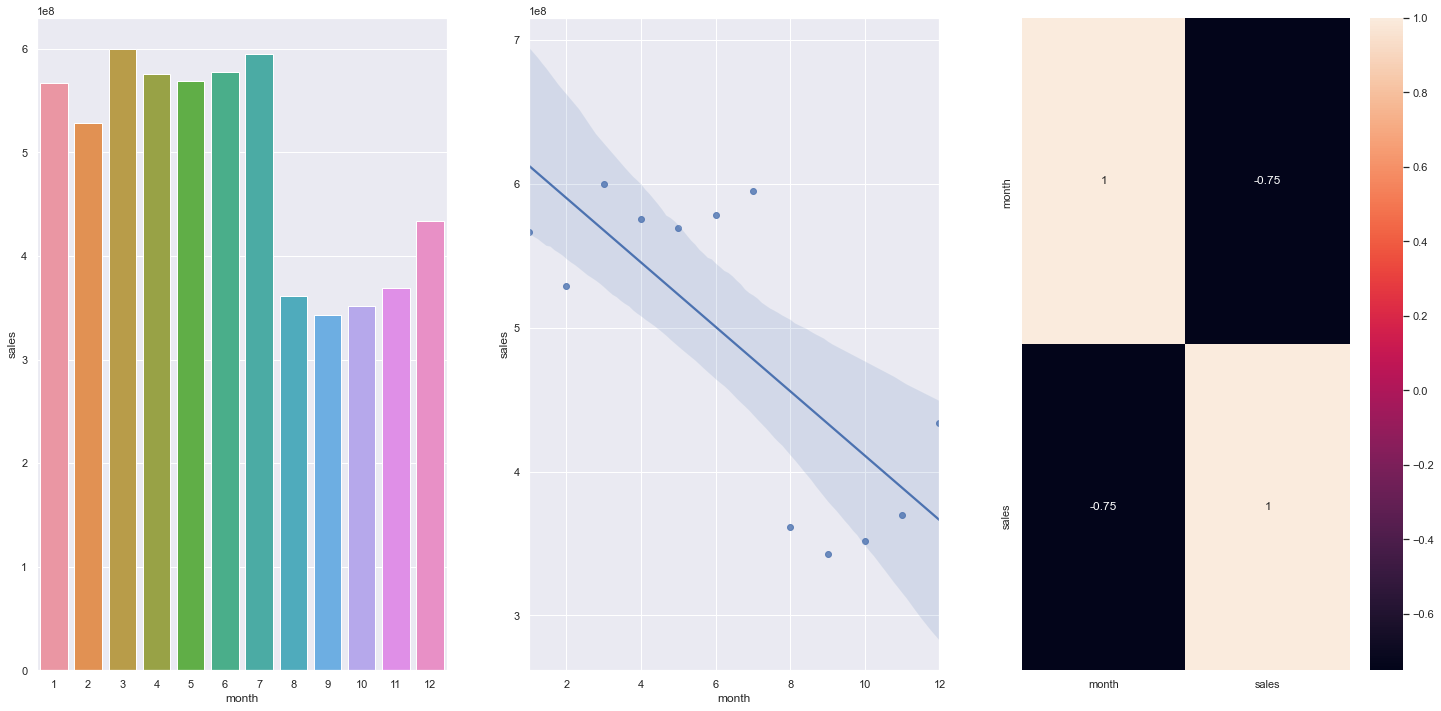

In [60]:
#criação do dataframe com as colunas da hipótese
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### Resumo da hipóteses

In [61]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [62]:
#criação de tabela: listas de listas
from tabulate import tabulate

In [63]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]

In [64]:
print( tabulate(tab, headers = 'firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3 Análise Multivariada
- Como as variáveis se relacionam ?

### 4.3.1 Numerical Attributes

<AxesSubplot:>

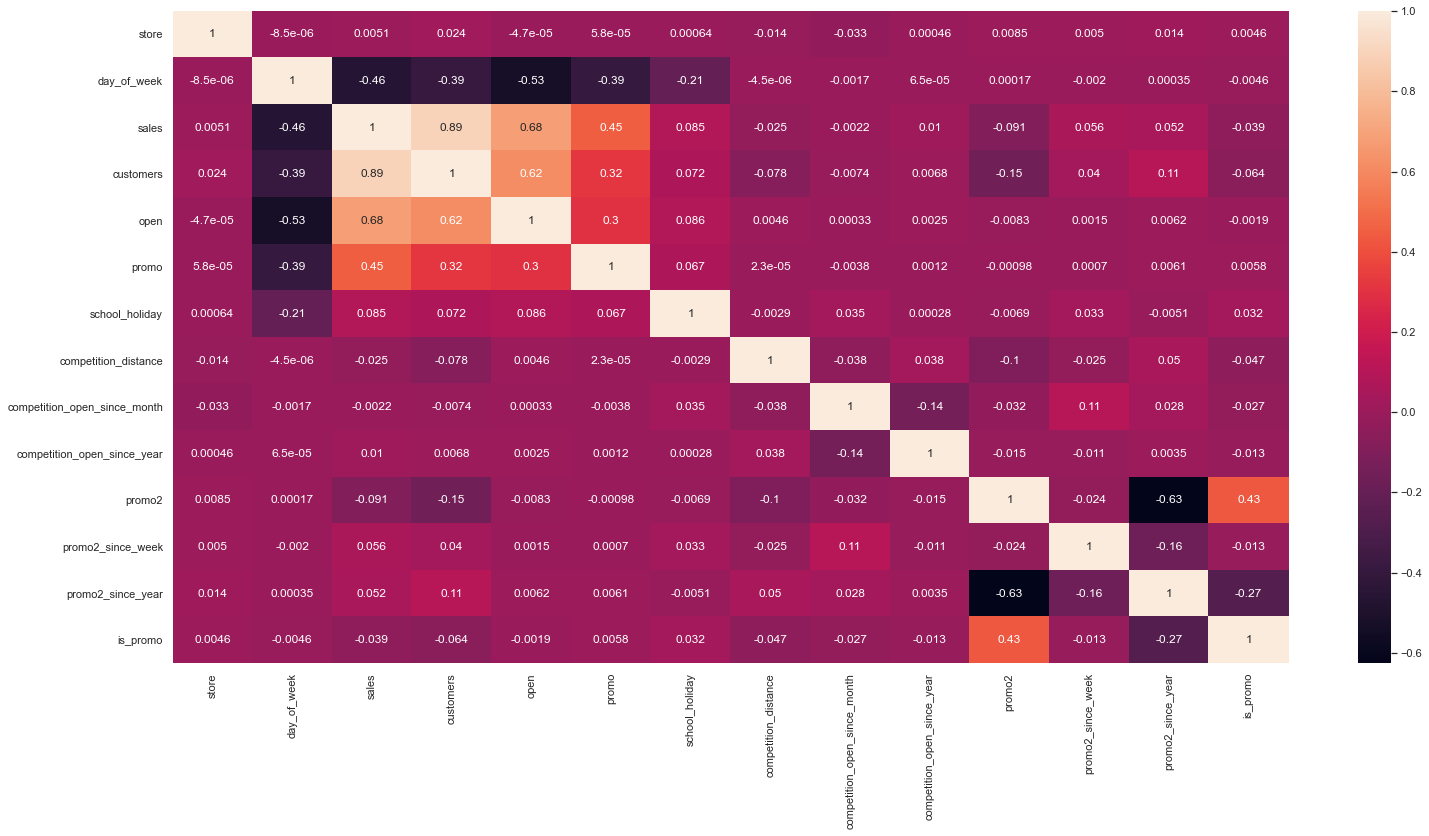

In [65]:
# cria uma tabela
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True)

### 4.3.2 Categorical Attributes

In [66]:
pip install PyCorr

Note: you may need to restart the kernel to use updated packages.


In [67]:
from scipy import stats as ss

from pycorrcat.pycorrcat import plot_corr, corr_matrix

In [68]:
# variáveis categóricas originais
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [69]:
# vamos usar as 3 colunas daqui como as variáveis categóricas (year week é date)
a = df4.select_dtypes( include = 'object')
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


#### Calculo do V de Cramer - Varia de 0 a 1

v = np.sqrt( (chi2/n) / (min ( k -1, r-1)))

#### Matriz de confusão ou tabela de contigência: todas as combinações entre as variáveis  categóricas passadas e conta o número de linhas das combinações

In [70]:
pd.crosstab ( a['state_holiday'], a['store_type'])

store_type,a,b,c,d
state_holiday,,,,
christmas,4,66,0,1
easter_holiday,36,100,0,9
public_holiday,236,285,65,108
regular_day,456766,15109,112903,258650


In [71]:
#cm = confusion matrix
# .values: pega somente os numeros do dataframe
cm = pd.crosstab ( a['state_holiday'], a['store_type']).values

In [72]:
chi2 = ss.chi2_contingency( cm )

In [73]:
# 4 valores: resultado do teste, P valor, graus de liberdade e tabela de frequência
chi2

(12792.159524019908,
 0.0,
 9,
 array([[3.84324548e+01, 1.30843335e+00, 9.49942795e+00, 2.17596839e+01],
        [7.84888161e+01, 2.67215262e+00, 1.94002402e+01, 4.44387911e+01],
        [3.75663713e+02, 1.27894753e+01, 9.28535634e+01, 2.12693248e+02],
        [4.56549415e+05, 1.55432299e+04, 1.12846247e+05, 2.58489108e+05]]))

In [74]:
chi2[0]

n = cm.sum()

r, k = cm.shape

In [75]:
v = np.sqrt( (chi2[0]/n) / min(k- 1, r - 1)   )

In [76]:
v 

0.07106457093267678

In [77]:
# definindo uma função para calcular o valor do v de cramer
def cramer_v( x, y ):
  cm = pd.crosstab( x, y ).to_numpy()
  n = cm.sum()
  r, k = cm.shape

  chi2 = ss.chi2_contingency( cm )[0]
  chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

  kcorr = k - (k-1)**2/(n-1)
  rcorr = r - (r-1)**2/(n-1)
  return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [78]:
cramer_v(a['state_holiday'], a['store_type'])

0.07106469715258833

#### utilizando PyCorr

In [79]:
#utilizando PyCorr
corr_matrix(a, ['state_holiday','store_type'])

,state_holiday,store_type
state_holiday,1.00000,0.07104
store_type,0.07104,1.00000


# 5.0 Data Preparation

- O aprendizado da maioria dos algoritmos de ML é facilitado com
dados numéricos, na mesma escala.
- Tipos de preparação de dados: Normalização, Rescaling e Transformação.
- Encoding: transformar variáveis categóricas para numéricas.

In [80]:
df5 = df4.copy()
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 5.1 Normalização

Como não temos nenhuma variável que tenha comportamento de uma normal, não vamos normalizar nada.

## 5.2 Rescaling

In [81]:
# pegando somente as variáveis numéricas
a = df5.select_dtypes(include = ['int64', 'float64'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,promo2,is_promo,year,month,day,week_of_year
0,1,5,5263,1,1,1270.0,0,0,2015,7,31,31
1,2,5,6064,1,1,570.0,1,1,2015,7,31,31
2,3,5,8314,1,1,14130.0,1,1,2015,7,31,31
3,4,5,13995,1,1,620.0,0,0,2015,7,31,31
4,5,5,4822,1,1,29910.0,0,0,2015,7,31,31


### Se a feature tiver outliers muito destacados, utilizo o RobustScaler

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


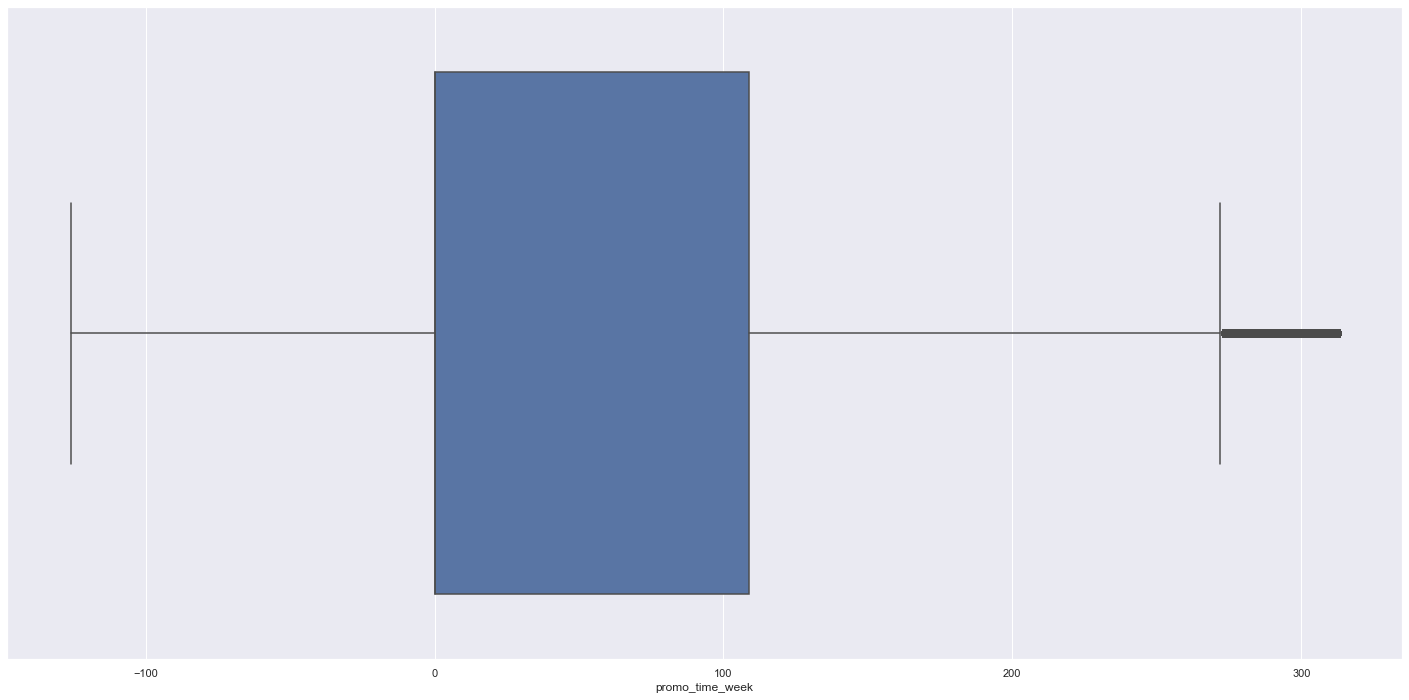

In [82]:
# verificação da competition_distance para ver se tem outliers:
sns.boxplot(df5['promo_time_week']);

In [83]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler

In [84]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )

In [85]:
df5[['competition_distance']].values

array([[-0.17096774],
       [-0.28387097],
       [ 1.90322581],
       ...,
       [-0.24032258],
       [-0.14516129],
       [-0.25967742]])

D:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

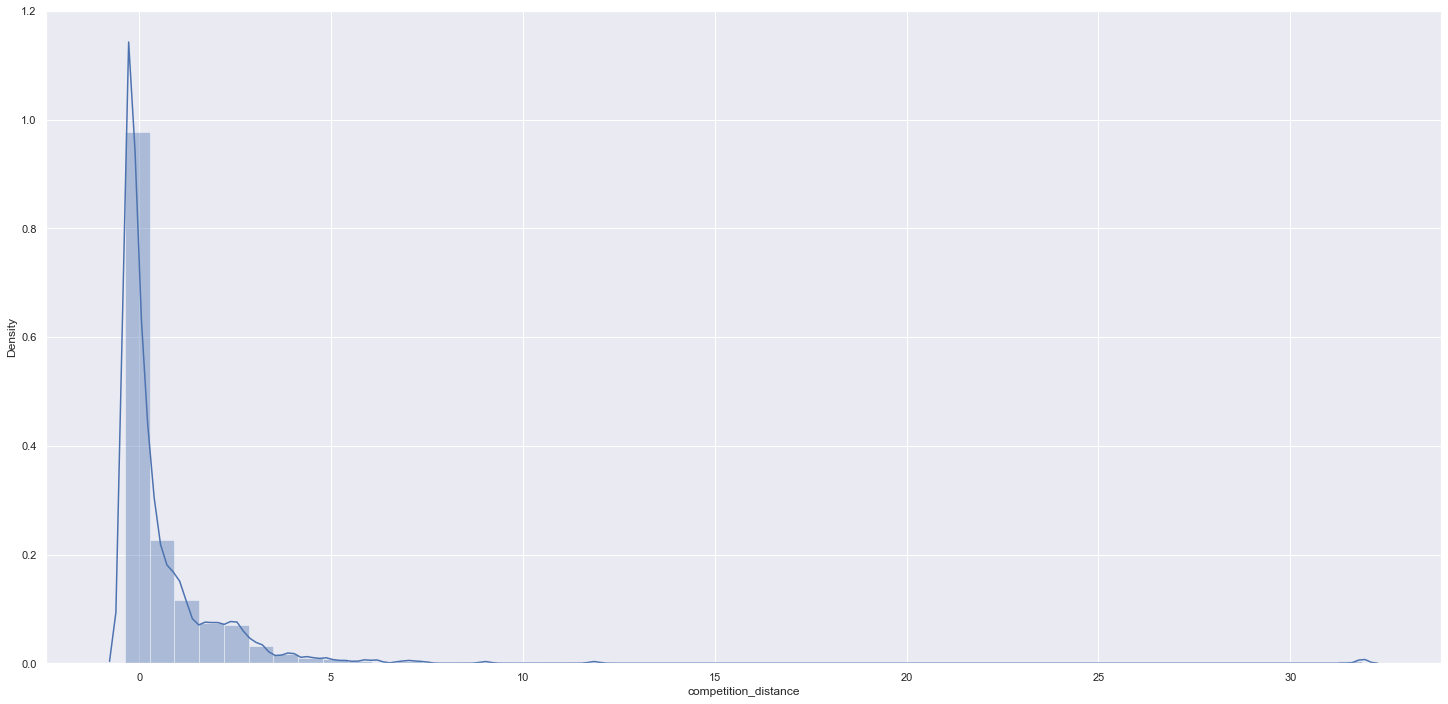

In [86]:
#competition distance com a nova escala.
sns.distplot(df5['competition_distance'])

## 5.3 Transformation

### Tipos de Encoding:
- One Hot Encoding: [1,0,0] [0,1,0] [0,0,1] 
- Label Encoding
- Ordinal Encoding
- Target Encoding
- Frequency Encoding
- Embedding Encoding

In [87]:
# variáveis cíclicas:
# month
# day
# week of year
#day of week